In [62]:
############################### Importing libraries ################################
# system tools
import os, sys, argparse
sys.path.append(os.path.join(".."))

# pandas, numpy, gensim
import pandas as pd
import numpy as np
import gensim.downloader
from heapq import nlargest
from scipy import stats

# import my classifier utility functions - see the Github repo!
import utils.classifier_utils as clf

# Machine learning stuff
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# tools from tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import L2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Embedding, 
                                     Flatten, GlobalMaxPool1D, Conv1D)
from tensorflow.keras.optimizers import SGD, Adam

# matplotlib
import matplotlib.pyplot as plt

In [63]:
############################### Defining functions to be used in main ###############################
def tokenize_X(X_train, X_test, num_words):
    '''
    Function that tokenizes X_train and X_test. 
    E.g. going from "She's your new queen too." to [172, 8, 275, 103, 129] - each word now has an index pointing to a vocabulary list.
    '''
    
    # Initialize tokenizer, using num_words as number of words
    tokenizer = Tokenizer(num_words = num_words)
    
    # Fit tokenizer to training data
    tokenizer.fit_on_texts(X_train)
    
    # Make tokens into sequences
    X_train_tokens = tokenizer.texts_to_sequences(X_train)
    X_test_tokens = tokenizer.texts_to_sequences(X_test)
    
    # Return the sequenized tokens
    return X_train_tokens, X_test_tokens, tokenizer

def apply_padding(X_train, X_test, maxlen, placement):
   
    # Apply padding to train
    X_train_pad = pad_sequences(X_train, 
                            padding = placement, # sequences can be padded "pre" or "post"
                            maxlen = maxlen)

    # Apply padding to test
    X_test_pad = pad_sequences(X_test, 
                           padding = placement, 
                           maxlen = maxlen)
    
    # Return padded elements
    return X_train_pad, X_test_pad

def create_embedding_matrix(filepath, word_index, embedding_dim):
    """ 
    A helper function to read in saved GloVe embeddings and create an embedding matrix
    
    filepath: path to GloVe embedding
    word_index: indices from keras Tokenizer
    embedding_dim: dimensions of keras embedding layer
    """
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

def plot_history(H, epoch, outpath):
    """
    Utility function for plotting model history using matplotlib
    
    H: model history 
    epochs: number of epochs for which the model was trained
    """
    plt.style.use("fivethirtyeight")
    plt.figure()
    plt.plot(np.arange(0, epoch), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epoch), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, epoch), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epoch), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.savefig(outpath, format='png', dpi=100)

In [64]:
inpath = os.path.join("data", "Game_of_Thrones_Script.csv")
epoch = 5
batchsize = 100
glovedim = 50
embedding_dim = 50

In [65]:
# Load in the data:
script = pd.read_csv(inpath)

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(script['Sentence'].values, # "Features" (sentences)
                                                    script['Season'].values, # Labels
                                                    test_size = 0.15, 
                                                    random_state = 42,
                                                    stratify = script['Season'].values) # If full dataset has 12% sentences from season 1, have 12% of sentences in train + test

# Tokenize X_train and X_test 
# (E.g. going from "She's your new queen too." to [172, 8, 275, 103, 129] - each word now has an index pointing to a vocabulary list.)
X_train_tokens, X_test_tokens, tokenizer = tokenize_X(X_train, X_test, 2500)

# Find lenght of longest quote in train
maxlen = max([len(elem) for elem in X_train]) # Maxlength to be longest element in X_train

# Apply padding to X_train and X_test
X_train, X_test = apply_padding(X_train_tokens, X_test_tokens, maxlen, "post")

[INFO] Commencing CNN training ...
Epoch 1/5
204/204 [==============================] - 91s 422ms/step - loss: 0.7616 - accuracy: 0.1628 - val_loss: 0.8826 - val_accuracy: 0.1636
Epoch 2/5
204/204 [==============================] - 84s 413ms/step - loss: 1.0155 - accuracy: 0.1645 - val_loss: 1.6167 - val_accuracy: 0.1636
Epoch 3/5
204/204 [==============================] - 85s 418ms/step - loss: 1.9475 - accuracy: 0.1613 - val_loss: 3.0926 - val_accuracy: 0.1636
Epoch 4/5
204/204 [==============================] - 86s 420ms/step - loss: 3.5761 - accuracy: 0.1634 - val_loss: 5.3037 - val_accuracy: 0.1636
Epoch 5/5
204/204 [==============================] - 91s 448ms/step - loss: 6.0380 - accuracy: 0.1644 - val_loss: 8.7358 - val_accuracy: 0.1636


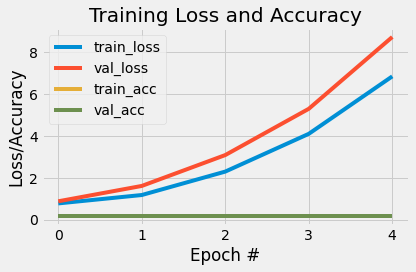

[INFO] A plot history report has been saved succesfully: "out/cnn_training_history.png"


AxisError: axis 1 is out of bounds for array of dimension 1

<Figure size 432x288 with 0 Axes>

In [66]:
# Encode labels from "Season 8" -> "8"
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_train_encoded = label_encoder.fit_transform(y_train)

# Defining overall vocabulary size (adding 1 because of reserved 0 index)
vocab_size = len(tokenizer.word_index) + 1 

# Create an embedding matrix, from glove (depending on argument)
if glovedim == 50:
    glove = "glove.6B.50d.txt"
elif glovedim == 100:
    glove = "glove.6B.100d.txt"

# Creating an embedding matrix
embedding_matrix = create_embedding_matrix(os.path.join("data", "glove", glove),
                                           tokenizer.word_index, 
                                           embedding_dim)

# Define model type, optimizer, layers and compile model
model = Sequential() # Initialize sequential model
opt = tf.keras.optimizers.Adam(learning_rate=0.001) # Define optimizer
# Add embedding layer
model.add(Embedding(input_dim = vocab_size, # Vocabulary size (from Tokenizer())
                    output_dim = embedding_dim, # Embedding dimensions as defined by argument
                    input_length = maxlen, # Input length should be length of inputs after padding
                    weights = [embedding_matrix], # Weights from the embedding matrix
                    trainable = False)) # Do not train on the embeddings

# CONV+ReLU -> MaxPool -> FC+ReLU -> Out
model.add(Conv1D(8, 3, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(8, kernel_regularizer=L2(0.1), activation='relu'))
model.add(Dense(1,  activation='softmax')) # softmax because multiclass
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy']) # Compile model (loss categorical - multiple classes)

# Train model
print(f"[INFO] Commencing CNN training ...")
history = model.fit(X_train, y_train_encoded,
                    epochs = epoch,
                    verbose = True,
                    validation_data = (X_test, y_test_encoded),
                    batch_size = batchsize)


# print plot of accuracy and loss over epochs and save it
outpath = os.path.join("out", 'cnn_training_history.png')
plot_history(history, epoch, outpath)
print(f"[INFO] A plot history report has been saved succesfully: \"{outpath}\"")

# Get predictions:
predictions = model.predict(X_test)

# Get classification report from predictions
classif_report = pd.DataFrame(classification_report(y_test.argmax(axis=1),
                                predictions.argmax(axis = 1),
                                target_names = labelNames, output_dict = True))

# If the folder does not already exist, create it
if not os.path.exists("out"):
    os.makedirs("out")

# Printing and saving classification_report
print(classif_report)
classif_report_outname = os.path.join("out", 'cnn_classification_report.csv')
classif_report.to_csv(classif_report_outname, sep=',', index = True)
print(f"A classification report has been saved succesfully: \"{classif_report_outname}\"")

# Print
loss, accuracy = model.evaluate(X_train_pad, y_train_encoded, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_pad, y_test_encoded, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))